In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import torch
plt.rcParams["font.family"] = "serif"

from astropy        import units, constants
from p3droslo.lines import Line
from p3droslo.loss  import Loss, diff_loss
from p3droslo.model import TensorModel, SphericalModel
from p3droslo.utils import print_var, planck

In [6]:
n_elements = 128

r_in   = (1.0e-1 * units.au).si.value
r_out  = (1.0e+4 * units.au).si.value


v_in  = (1.0e+0 * units.km / units.s).si.value
v_inf = (2.0e+1 * units.km / units.s).si.value
beta  = 0.5

T_in    = (2.5e+3 * units.K).si.value
epsilon = 0.6

Mdot   = (1.0e-6 * units.M_sun / units.yr).si.value
v_turb = (1.5e+0 * units.km    / units.s ).si.value
T_star = (2.5e+3 * units.K               ).si.value
R_star = (1.0e+0 * units.au              ).si.value

model = TensorModel(sizes=r_out, shape=n_elements)

rs = np.logspace(np.log10(r_in), np.log10(r_out), n_elements, dtype=np.float64)
# rs = np.linspace(         r_in ,          r_out , n_elements, dtype=np.float64)

v = np.empty_like(rs)
v[rs <= R_star] = 0.0
v[rs >  R_star] = v_in + (v_inf - v_in) * (1.0 - R_star / rs[rs > R_star])**beta

rho  = Mdot / (4.0 * np.pi * rs**2 * v)
n_CO = (1.0e-4 * constants.N_A.si.value / 2.02e-3) * rho
n_CO[rs<=R_star] = n_CO[n_CO<np.inf].max()


# Define and initialise the model variables
model['log_r'         ] = np.log(rs)
model['log_CO'        ] = np.log(n_CO)
model['log_turbulence'] = np.log(v_turb) * np.ones(n_elements)
model['log_v_in'      ] = np.log(v_in)
model['log_v_inf'     ] = np.log(v_inf)
model['log_beta'      ] = np.log(beta)
model['log_T_in'      ] = np.log(T_in)
model['log_epsilon'   ] = np.log(epsilon)
model['log_T_star'    ] = np.log(T_star)
model['log_R_star'    ] = np.log(R_star)

model.fix_all()

# Line data
lines = [Line('CO', i) for i in range(10)]

# Frequency data
vdiff = 300   # velocity increment size [m/s]
nfreq = 100   # number of frequencies

velocities  = nfreq * vdiff * torch.linspace(-1, +1, nfreq, dtype=torch.float64)
frequencies = [(1.0 + velocities / constants.c.si.value) * line.frequency for line in lines]


def get_velocity(model):

    r      = torch.exp(model['log_r'])
    v_in   = torch.exp(model['log_v_in'])
    v_inf  = torch.exp(model['log_v_inf'])
    beta   = torch.exp(model['log_beta'])
    R_star = torch.exp(model['log_R_star'])

    v = torch.empty_like(r)
    v[r <= R_star] = 0.0
    v[r >  R_star] = v_in + (v_inf - v_in) * (1.0 - R_star / r[r > R_star])**beta
    # Return
    return v


def get_temperature(model):

    r       = torch.exp(model['log_r'])
    T_in    = torch.exp(model['log_T_in'])
    epsilon = torch.exp(model['log_epsilon'])
    R_star  = torch.exp(model['log_R_star'])
    
    T = torch.empty_like(r)    
    T[r <= R_star] = T_in
    T[r >  R_star] = T_in * (R_star / r[r > R_star])**epsilon
    # Return
    return T


def get_abundance(model):
    return torch.exp(model['log_CO'])


def get_turbulence(model):
    return torch.exp(model['log_turbulence'])


def get_boundary_condition(model, frequency, b):

        T_star = torch.exp(model['log_T_star'])
        R_star = torch.exp(model['log_R_star'])

        T_CMB = 2.72548

        if b > R_star:
            return planck(temperature=T_CMB, frequency=frequency)
        else:
            return planck(temperature=T_star, frequency=frequency)


smodel = SphericalModel(rs, model, r_star=R_star)
smodel.get_velocity           = get_velocity
smodel.get_abundance          = get_abundance
smodel.get_turbulence         = get_turbulence
smodel.get_temperature        = get_temperature
smodel.get_boundary_condition = get_boundary_condition

/tmp/ipykernel_1000012/4005250844.py:28: RuntimeWarning: divide by zero encountered in true_divide
  rho  = Mdot / (4.0 * np.pi * rs**2 * v)


You have selected line:
    CO(J=1-0)
Please check the properties that were inferred:
    Frequency         1.152712018e+11  Hz
    Einstein A coeff  7.203000000e-08  1/s
    Molar mass        28.0101          g/mol
You have selected line:
    CO(J=2-1)
Please check the properties that were inferred:
    Frequency         2.305380000e+11  Hz
    Einstein A coeff  6.910000000e-07  1/s
    Molar mass        28.0101          g/mol
You have selected line:
    CO(J=3-2)
Please check the properties that were inferred:
    Frequency         3.457959899e+11  Hz
    Einstein A coeff  2.497000000e-06  1/s
    Molar mass        28.0101          g/mol
You have selected line:
    CO(J=4-3)
Please check the properties that were inferred:
    Frequency         4.610407682e+11  Hz
    Einstein A coeff  6.126000000e-06  1/s
    Molar mass        28.0101          g/mol
You have selected line:
    CO(J=5-4)
Please check the properties that were inferred:
    Frequency         5.762679305e+11  Hz
    Eins

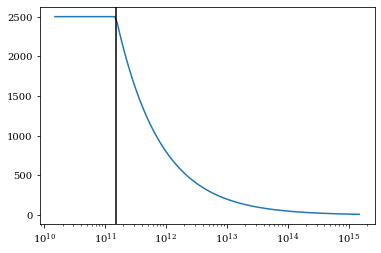

In [7]:
plt.plot(rs, get_temperature(model))
plt.xscale('log')
plt.axvline(x=R_star, color='k')

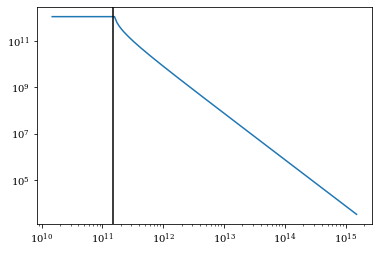

In [8]:
plt.plot(rs, get_abundance(model))
plt.xscale('log')
plt.axvline(x=R_star, color='k')
plt.yscale('log')

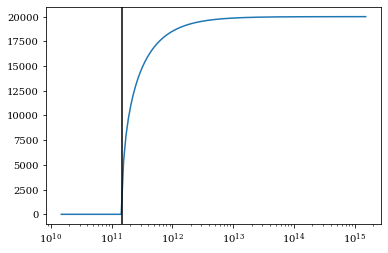

In [9]:
plt.plot(rs, get_velocity(model))
plt.xscale('log')
plt.axvline(x=R_star, color='k')
# plt.ylim((10000, 20000))

In [10]:
obss = smodel.image(lines, frequencies, r_max=1.0*r_out)

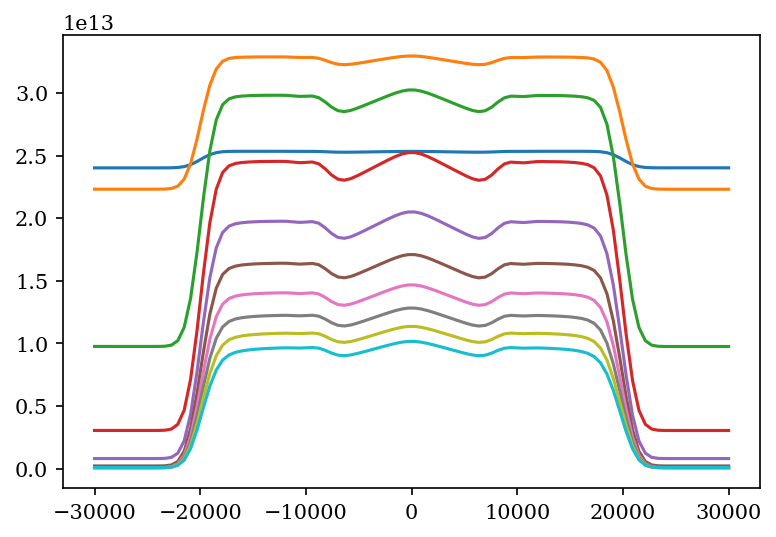

In [11]:
plt.figure(dpi=150)
for obs in obss:
    plt.plot(velocities, obs.data)
    # plt.yscale('log')

In [ ]:
bg subtract
- density voor CO 1-0, 2-1, 4-3, 6-5
- density voor HCN (later)

- massverlies apart fitten?

In [63]:
log_n_CO_init = np.log(1.0e+17*(rs.min()/rs)**2)

smodel.model_1D['log_CO'] = log_n_CO_init.copy()
# smodel.model_1D.free(['log_CO', 'log_v_in', 'log_v_inf', 'log_beta', 'log_T_in', 'log_epsilon'])
smodel.model_1D.free(['log_CO'])

losses = Loss(['avg', 'rel', 'reg', 'cnt'])

In [9]:
imgs = smodel.image(lines, frequencies, r_max=r_max)

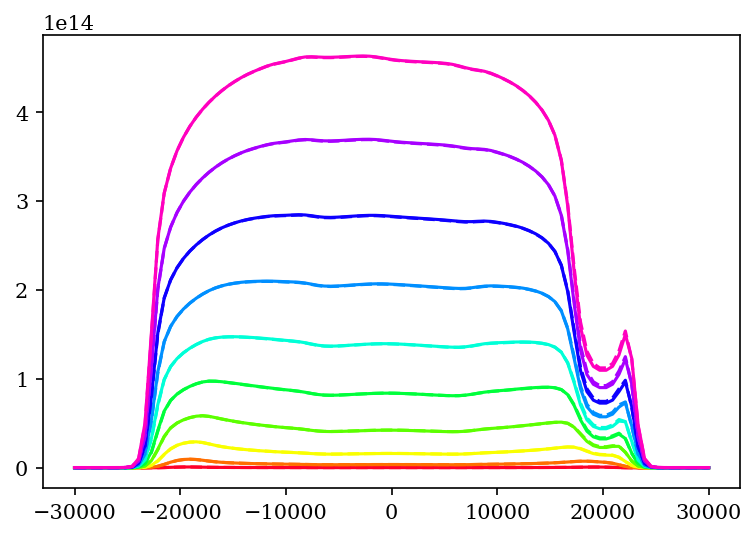

In [20]:
plt.figure(dpi=150)

colors = plt.cm.gist_rainbow(np.linspace(0, 1, len(imgs)))

for i, (img, obs) in enumerate(zip(imgs, obss)):
    plt.plot(velocities, img.data, linestyle='-',  c=colors[i])
    plt.plot(velocities, obs.data, linestyle='--', c=colors[i])
    # plt.yscale('log')

In [11]:
def steady_state_cont_loss(smodel):
    """
    Loss assuming steady state hydrodynamics, i.e. vanishing time derivatives.
    """
    # Get the model variables
    rho = smodel.get_abundance(smodel.model_1D)
    v_r = smodel.get_velocity (smodel.model_1D)
    r   = torch.from_numpy(smodel.rs)

    # Continuity equation (steady state): div(ρ v) = 0
    loss_cont = smodel.model_1D.diff_x(r**2 * rho * v_r)

    # Compute the mean squared losses
    loss = torch.mean((loss_cont/((r**2)*rho))**2)

    # Return losses
    return loss

In [12]:
from torch.optim import Adam
from tqdm        import tqdm

obss_avg = obss.mean(axis=1)
obss_rel = torch.einsum("ij, i -> ij", obss, 1.0 / obss.mean(axis=1))

# Get a mask for the elements outsife the star
outside_star = torch.from_numpy(smodel.rs) > torch.exp(smodel.model_1D['log_R_star'])
        

def fit(losses, smodel, lines, frequencies, obss, N_epochs=10, lr=1.0e-1, w_avg=1.0, w_rel=1.0, w_reg=1.0, w_cnt=1.0):

    params = [
        smodel.model_1D['log_CO'],
        # smodel.model_1D['log_v_in'],
        # smodel.model_1D['log_v_inf'],
        # smodel.model_1D['log_beta'],
        # smodel.model_1D['log_T_in'],
        # smodel.model_1D['log_epsilon'],
    ]

    abundance_evol = [smodel.get_abundance(smodel.model_1D).detach().clone()]
    
    optimizer = Adam(params, lr=lr)

    for _ in tqdm(range(N_epochs)):

        # Forward model
        imgs = smodel.image(lines, frequencies, r_max=r_max)

        imgs_avg= imgs.mean(axis=1)
        imgs_rel= torch.einsum("ij, i -> ij", imgs, 1.0 / imgs.mean(axis=1))

        # Compute the reproduction loss
        losses['avg'] = w_avg * torch.nn.functional.mse_loss(imgs_avg, obss_avg)
        losses['rel'] = w_rel * torch.nn.functional.mse_loss(imgs_rel, obss_rel)
        # Compute the regularisation loss
        losses['reg'] = w_reg * diff_loss(smodel.model_1D['log_CO'][outside_star])
        # Compute the hydrodynamic loss   
        losses['cnt'] = w_cnt * steady_state_cont_loss(smodel)   

        # Set gradients to zero
        optimizer.zero_grad()
        # Backpropagate gradients
        losses.tot().backward()
        # Update parameters
        optimizer.step()

        abundance_evol.append(smodel.get_abundance(smodel.model_1D).detach().clone())

    return imgs, losses, abundance_evol

In [13]:
imgs, losses, a_evol = fit(losses, smodel, lines, frequencies, obss, N_epochs=3, lr=1.0e-1, w_avg=1.0, w_rel=1.0e+0, w_reg=1.0e-0, w_cnt=1.0e+0)

losses.renormalise_all()
losses.reset()

  0%|          | 0/3 [00:00<?, ?it/s]/home/frederikd/.local/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 3/3 [00:18<00:00,  6.17s/it]


In [14]:
# imgs, loss, a_evol = fit(losses, smodel, lines, frequencies, obss, N_epochs=10, lr=1.0e-1, w_avg=1.0, w_rel=1.0e+0, w_reg=1.0e-0, w_cnt=1.0e+0)

In [15]:
imgs, loss, a_evol = fit(losses, smodel, lines, frequencies, obss, N_epochs=250, lr=1.0e-1, w_avg=1.0, w_rel=1.0e+0, w_reg=1.0e-0, w_cnt=1.0e+0)

100%|██████████| 250/250 [40:33<00:00,  9.73s/it]


In [16]:
smodel.model_1D.save('smodel_1d_a_17')

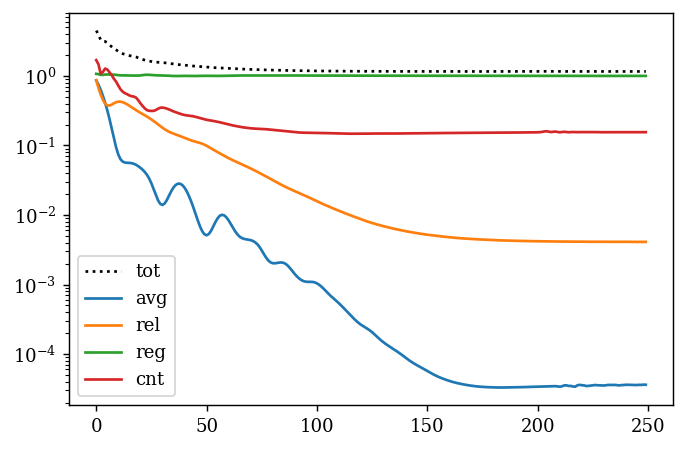

In [17]:
loss.plot()

In [18]:
print(torch.exp(smodel.model_1D['log_T_in'   ]).item(), T_in)
print(torch.exp(smodel.model_1D['log_epsilon']).item(), epsilon)
print(torch.exp(smodel.model_1D['log_v_in'   ]).item(), v_in)
print(torch.exp(smodel.model_1D['log_v_inf'  ]).item(), v_inf)
print(torch.exp(smodel.model_1D['log_beta'   ]).item(), beta)

5000.000000000004 5000.0
0.3 0.3
999.9999999999998 1000.0
19999.99999999998 20000.0
0.5 0.5


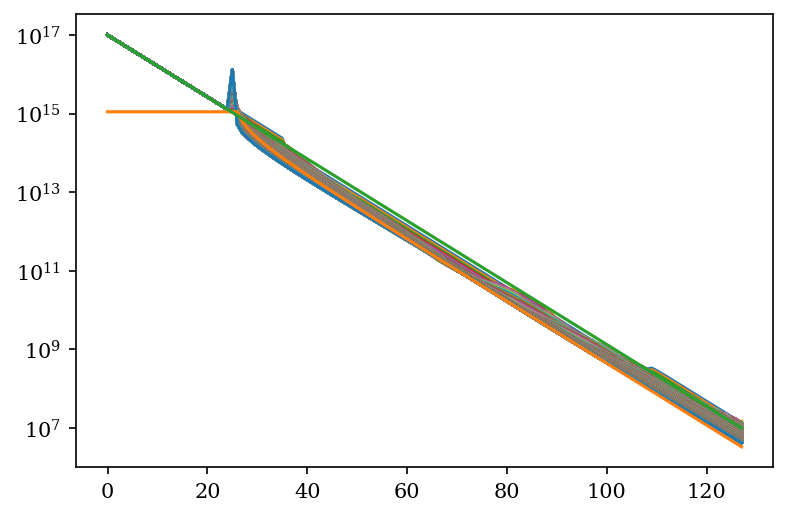

In [22]:
plt.figure(dpi=150)
for CO in a_evol[:]:
    plt.plot(CO)
plt.plot(n_CO)
plt.plot(np.exp(log_n_CO_init))
plt.yscale('log')



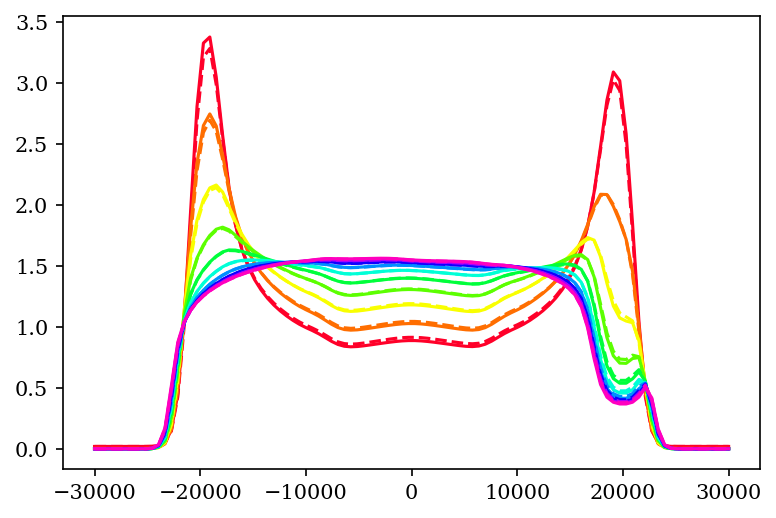

In [20]:
plt.figure(dpi=150)

colors = plt.cm.gist_rainbow(np.linspace(0, 1, len(imgs)))

for i, (img, obs) in enumerate(zip(imgs, obss)):
    plt.plot(velocities, img.data / img.data.mean(), linestyle='-',  c=colors[i])
    plt.plot(velocities, obs.data / obs.data.mean(), linestyle='--', c=colors[i])
    # plt.plot(velocities, np.abs(obs.data / obs.data.mean() - img.data / img.data.mean()), linestyle='--', c=colors[i])
    # plt.yscale('log')